In [1]:
import numpy as np
import pandas as pd
import glob
import os

# ---- CONFIG ----
NPY_GLOB = "../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/Test/Unlabeled/*.npy"   # <- update this to your path
FEATURE_COLS = [5, 6, 7, 8]           # 0-based indices (7th–10th features)

def summarize_block(X, already_selected=False):
    """
    X: 2D array. If already_selected=False, X is (N, 23) and we will select FEATURE_COLS.
       If already_selected=True, X is (N, len(FEATURE_COLS)) and will be used directly.
    Returns a DataFrame with stats per selected feature column.
    """
    if X.size == 0:
        idx = [f"col_{c}" for c in FEATURE_COLS]
        cols = ["count", "nonzero_count", "mean", "std", "min", "p25", "p50", "p75", "max"]
        return pd.DataFrame(0, index=idx, columns=cols, dtype=float)

    if not already_selected:
        sel = X[:, FEATURE_COLS]  # shape: (N, 4)
    else:
        sel = X
        if sel.shape[1] != len(FEATURE_COLS):
            raise ValueError(f"Expected {len(FEATURE_COLS)} selected columns, got {sel.shape[1]}")

    count = sel.shape[0]
    nonzero_count = (sel != 0).sum(axis=0)

    mean = np.nanmean(sel, axis=0)
    std  = np.nanstd(sel, axis=0, ddof=1) if sel.shape[0] > 1 else np.zeros(sel.shape[1])
    vmin = np.nanmin(sel, axis=0)
    p25  = np.nanpercentile(sel, 25, axis=0)
    p50  = np.nanpercentile(sel, 50, axis=0)
    p75  = np.nanpercentile(sel, 75, axis=0)
    vmax = np.nanmax(sel, axis=0)

    df = pd.DataFrame({
        "count":         count,
        "nonzero_count": nonzero_count,
        "mean":          mean,
        "std":           std,
        "min":           vmin,
        "p25":           p25,
        "p50":           p50,
        "p75":           p75,
        "max":           vmax,
    }, index=[f"col_{c}" for c in FEATURE_COLS])

    return df

def process_npy_file(path):
    arr = np.load(path)  # expected shape: (30,30,30,23)
    if arr.ndim != 4 or arr.shape[-1] != 23:
        raise ValueError(f"Unexpected shape for {path}: {arr.shape} (expected *,*,*,23)")

    flat = arr.reshape(-1, arr.shape[-1])     # (27000, 23)
    mask = np.any(flat != 0, axis=1)          # rows where any feature is non-zero
    filtered = flat[mask]                     # (M, 23)

    stats_df = summarize_block(filtered, already_selected=False)
    stats_df.insert(0, "file", os.path.basename(path))
    stats_df.insert(1, "rows_kept", filtered.shape[0])

    # also return just the selected columns for global aggregation
    return stats_df, filtered[:, FEATURE_COLS]


files = sorted(glob.glob(NPY_GLOB, recursive=True))
if not files:
    raise SystemExit(f"No .npy files matched glob: {NPY_GLOB}")

per_file_rows = []
all_sel_values = []

for f in files:
    try:
        stats_df, sel_cols = process_npy_file(f)
        per_file_rows.append(stats_df)
        if sel_cols.size > 0:
            all_sel_values.append(sel_cols)
    except Exception as e:
        print(f"[WARN] Skipping {f}: {e}")

if not per_file_rows:
    raise SystemExit("No valid files processed; check shapes/paths.")

per_file_stats = pd.concat(per_file_rows, axis=0)
per_file_stats.to_csv("per_file_stats_cols_5_8.csv", index=True)
print("Saved per-file stats -> per_file_stats_cols_5_8.csv")

if all_sel_values:
    all_vals = np.vstack(all_sel_values)  # shape: (sum_M, 4)
    # ✅ all_vals already has only the selected columns
    global_df = summarize_block(all_vals, already_selected=True)
    global_df.insert(0, "file", "__ALL__")
    global_df.insert(1, "rows_kept", all_vals.shape[0])
    global_df.to_csv("global_stats_cols_5_8.csv", index=True)
    print("Saved global stats  -> global_stats_cols_5_8.csv")
else:
    print("No rows with any non-zero feature found across files; no global stats saved.")



Saved per-file stats -> per_file_stats_cols_5_8.csv
Saved global stats  -> global_stats_cols_5_8.csv


/tmp/ipykernel_2240853/3964320162.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showmeans=True, meanline=True)


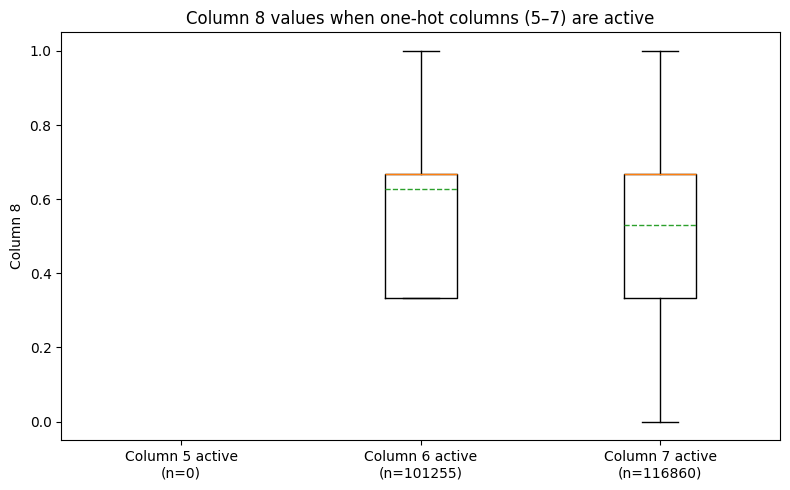

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# all_vals shape: (N, 4) -> [col5, col6, col7, col8]
df = pd.DataFrame(all_vals, columns=["c5", "c6", "c7", "c8"]).replace([np.inf, -np.inf], np.nan).dropna()

groups = []
labels = []
for i, label in enumerate(["Column 5 active", "Column 6 active", "Column 7 active"]):
    mask = df.iloc[:, i] != 0  # one-hot active
    vals = df.loc[mask, "c8"].to_numpy()
    groups.append(vals if vals.size else np.array([np.nan]))  # keep slot even if empty
    labels.append(f"{label}\n(n={vals.size})")

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(groups, labels=labels, showmeans=True, meanline=True)
ax.set_ylabel("Column 8")
ax.set_title("Column 8 values when one-hot columns (5–7) are active")
plt.tight_layout()
plt.show()


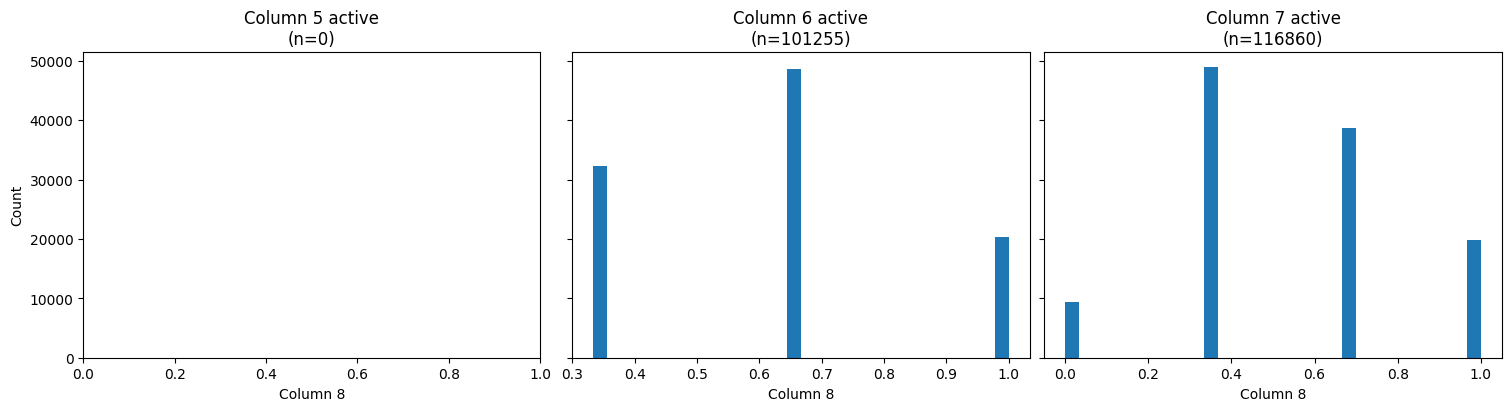

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, constrained_layout=True)
names = ["Column 5 active", "Column 6 active", "Column 7 active"]

for ax, i, name in zip(axes, [0, 1, 2], names):
    vals = df.loc[df.iloc[:, i] != 0, "c8"].to_numpy()
    if vals.size > 0:
        ax.hist(vals, bins=30)
    ax.set_title(f"{name}\n(n={vals.size})")
    ax.set_xlabel("Column 8")
axes[0].set_ylabel("Count")
plt.show()


In [4]:
import numpy as np
import glob
import os

# ---- CONFIG ----
NPY_GLOB = "../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/Test/Positive/*.npy"
CHECK_COLS = [5, 6, 7, 8]   # 0-based indices

files = sorted(glob.glob(NPY_GLOB, recursive=True))
if not files:
    raise SystemExit(f"No .npy files matched glob: {NPY_GLOB}")

matching_files = []

for f in files:
    arr = np.load(f)
    if arr.ndim != 4 or arr.shape[-1] <= max(CHECK_COLS):
        print(f"[WARN] Skipping {f}, unexpected shape {arr.shape}")
        continue
    
    flat = arr.reshape(-1, arr.shape[-1])  # (N, 23)
    # Check if any value in columns 5–8 is exactly 0.5
    if np.any(np.isclose(flat[:, CHECK_COLS], 0.5)):
        matching_files.append(os.path.basename(f))

print("Files with value 0.5 in columns 5–8:")
for fname in matching_files:
    print(fname)

print(len(matching_files), "is number of files with 0.5")

if not matching_files:
    print("No files contained value 0.5 in columns 5–8.")


Files with value 0.5 in columns 5–8:
6IBB-filtered_grid_0.npy
6IBB-filtered_grid_1.npy
6IBB-filtered_grid_2.npy
6IBB-filtered_grid_3.npy
6IBB-filtered_grid_4.npy
7MIX-filtered_grid_0.npy
7MIX-filtered_grid_1.npy
7MIX-filtered_grid_2.npy
7MIX-filtered_grid_3.npy
7MIX-filtered_grid_4.npy
7PXE-filtered_grid_0.npy
7PXE-filtered_grid_1.npy
7PXE-filtered_grid_2.npy
7PXE-filtered_grid_3.npy
7PXE-filtered_grid_4.npy
7PXG-filtered_grid_0.npy
7PXG-filtered_grid_1.npy
7PXG-filtered_grid_2.npy
7PXG-filtered_grid_3.npy
7PXG-filtered_grid_4.npy
7SMR-filtered_grid_0.npy
7SMR-filtered_grid_1.npy
7SMR-filtered_grid_2.npy
7SMR-filtered_grid_3.npy
7SMR-filtered_grid_4.npy
7SMT-filtered_grid_0.npy
7SMT-filtered_grid_1.npy
7SMT-filtered_grid_2.npy
7SMT-filtered_grid_3.npy
7SMT-filtered_grid_4.npy
8EOG-filtered_grid_0.npy
8EOG-filtered_grid_1.npy
8EOG-filtered_grid_2.npy
8EOG-filtered_grid_3.npy
8EOG-filtered_grid_4.npy
8F7S-filtered_grid_0.npy
8F7S-filtered_grid_1.npy
8F7S-filtered_grid_2.npy
8F7S-filtered

In [5]:
import numpy as np
import glob
import os

# ---- CONFIG ----
NPY_GLOB = "../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/Test/Positive/*.npy"
COL7, COL8 = 7, 8   # 0-based indices

files = sorted(glob.glob(NPY_GLOB, recursive=True))
if not files:
    raise SystemExit(f"No .npy files matched glob: {NPY_GLOB}")

counts_per_file = []      # number of rows per file where (col7 != 0) & (col8 == 0)
matching_files = []       # filenames with at least one match
example_row = None
example_file = None

for f in files:
    arr = np.load(f)
    if arr.ndim != 4 or arr.shape[-1] <= max(COL7, COL8):
        print(f"[WARN] Skipping {f}, unexpected shape {arr.shape}")
        continue

    flat = arr.reshape(-1, arr.shape[-1])  # (N, 23)
    mask = (flat[:, COL7] != 0) & (flat[:, COL8] == 0)

    occ = int(np.count_nonzero(mask))
    counts_per_file.append(occ)

    if occ > 0:
        matching_files.append(os.path.basename(f))
        if example_row is None:
            idx = np.where(mask)[0][0]
            example_row = flat[idx]
            example_file = os.path.basename(f)

# --- Summary stats ---
num_files_total = len(counts_per_file)
num_files_with_matches = len(matching_files)
avg_all_files = (np.mean(counts_per_file) if counts_per_file else 0.0)
avg_only_matching = (np.mean([c for c in counts_per_file if c > 0]) 
                     if any(c > 0 for c in counts_per_file) else 0.0)

print(f"Total files scanned: {num_files_total}")
print(f"Files with at least one (col7!=0 & col8==0): {num_files_with_matches}")
print(f"Average matches per file (including zeros): {avg_all_files:.3f}")
print(f"Average matches per matching file only: {avg_only_matching:.3f}")

print("\nMatching files:")
for fname in matching_files:
    print(fname)

if example_row is not None:
    print(f"\nExample row from {example_file}:\n{example_row}")


Total files scanned: 770
Files with at least one (col7!=0 & col8==0): 755
Average matches per file (including zeros): 4.481
Average matches per matching file only: 4.570

Matching files:
1LRI-filtered_grid_0.npy
1LRI-filtered_grid_1.npy
1LRI-filtered_grid_2.npy
1LRI-filtered_grid_3.npy
1LRI-filtered_grid_4.npy
2RH1-filtered_grid_0.npy
2RH1-filtered_grid_1.npy
2RH1-filtered_grid_2.npy
2RH1-filtered_grid_3.npy
2RH1-filtered_grid_4.npy
3NY9-filtered_grid_0.npy
3NY9-filtered_grid_1.npy
3NY9-filtered_grid_2.npy
3NY9-filtered_grid_3.npy
3NY9-filtered_grid_4.npy
3NYA-filtered_grid_0.npy
3NYA-filtered_grid_1.npy
3NYA-filtered_grid_2.npy
3NYA-filtered_grid_3.npy
3NYA-filtered_grid_4.npy
4BOE-filtered_grid_0.npy
4BOE-filtered_grid_1.npy
4BOE-filtered_grid_2.npy
4BOE-filtered_grid_3.npy
4BOE-filtered_grid_4.npy
4OR2-filtered_grid_0.npy
4OR2-filtered_grid_1.npy
4OR2-filtered_grid_2.npy
4OR2-filtered_grid_3.npy
4OR2-filtered_grid_4.npy
4XNU-filtered_grid_0.npy
4XNU-filtered_grid_1.npy
4XNU-filtered

In [ ]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from collections import Counter

# ---- CONFIG ----
NPY_GLOB = "../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/Test/Positive/*.npy"
COL10 = 13   # column 10 (0-based index)
COL13 = 10  # column 13 (0-based index)

files = sorted(glob.glob(NPY_GLOB, recursive=True))
if not files:
    raise SystemExit(f"No .npy files matched glob: {NPY_GLOB}")

all_values = []

for f in files:
    arr = np.load(f)
    if arr.ndim != 4 or arr.shape[-1] <= max(COL10, COL13):
        print(f"[WARN] Skipping {f}, unexpected shape {arr.shape}")
        continue

    flat = arr.reshape(-1, arr.shape[-1])  # (N, 23)

    # Mask: rows where col13 is nonzero
    mask = flat[:, COL13] != 0
    values_col10 = flat[mask, COL10]  # take col10 values where col13 ≠ 0
    all_values.extend(values_col10.tolist())

# ---- Analysis ----
print(f"Collected {len(all_values)} values from column 10 where column 13 ≠ 0 across {len(files)} files")

# Count unique values
value_counts = Counter(all_values)
print("\nTop 10 most common values in column 10 (when col13 ≠ 0):")
for val, cnt in value_counts.most_common(10):
    print(f"{val}: {cnt}")

# ---- Plot ----
plt.figure(figsize=(10, 6))

# If values are small integers, bar chart works better
if all(float(v).is_integer() and abs(v) < 50 for v in all_values):
    keys, counts = zip(*sorted(value_counts.items()))
    plt.bar(keys, counts)
    plt.xlabel("Column 10 Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Column 10 Values (when Column 13 ≠ 0)")
else:
    # Continuous → histogram
    plt.hist(all_values, bins=50, edgecolor="black")
    plt.xlabel("Column 10 Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Column 10 Values (when Column 13 ≠ 0)")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import glob
import pandas as pd
from collections import Counter

# ---- CONFIG ----
NPY_GLOB = "../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/Test/Positive/*.npy"

feature_labels = [
    "C", "N", "O", "S", "H",                         # 0–4 Atom type
    "SP", "SP2", "SP3",                              # 5–7 Hybridization
    "#OfBonds", "#HeteroAtoms",                      # 8–9
    "Aromatic", "ChargePresent", "ChargeSign",       # 10–12
    "InRing",                                        # 13
    "Acidic", "Basic", "Histidine", "Cysteine",      # 14–17
    "PolarUncharged", "Glycine", "Proline",          # 18–20
    "AromaticResidue", "Hydrophobic"                 # 21–22
]

DISCRETE_LEVELS = {0.33: 1, 0.5: 1, 0.66: 2, 1.0: 3}
def round3(x): return float(np.round(x, 3))

def map_discrete_levels(values):
    uniq = sorted({round3(v) for v in values if v != 0})
    present = [u for u in uniq if u in DISCRETE_LEVELS]
    return ", ".join(f"{u}→{DISCRETE_LEVELS[u]}" for u in present) if present else ""

# ---- Load data ----
files = sorted(glob.glob(NPY_GLOB, recursive=True))
if not files:
    raise SystemExit("No .npy files matched glob.")

all_data = []
for f in files:
    arr = np.load(f)
    if arr.ndim != 4 or arr.shape[-1] != len(feature_labels):
        print(f"[WARN] Skipping {f}, unexpected shape {arr.shape}")
        continue
    all_data.append(arr.reshape(-1, arr.shape[-1]))

data = np.vstack(all_data)  # (total_rows, 23)
total_rows = data.shape[0]

# ---- Compute stats ----
rows = []
for idx, name in enumerate(feature_labels):
    col = data[:, idx]
    nonzero = col[col != 0]
    nz_count = nonzero.size
    nz_pct = (nz_count / total_rows * 100.0) if total_rows else 0.0

    if nz_count > 0:
        vals_rounded = [round3(v) for v in nonzero]
        mode_val = Counter(vals_rounded).most_common(1)[0][0]
        rows.append({
            "Feature": name,
            "Non-zero Count": int(nz_count),
            "Non-zero %": nz_pct,
            "Min": float(nonzero.min()),
            "Median": float(np.median(nonzero)),
            "Mean": float(nonzero.mean()),
            "Max": float(nonzero.max()),
            "Range": None,  # fill after rounding to keep numeric types clean
            "Mode (non-zero)": float(mode_val),
            "Levels present (mapped)": map_discrete_levels(nonzero)
        })
    else:
        rows.append({
            "Feature": name,
            "Non-zero Count": 0,
            "Non-zero %": 0.0,
            "Min": np.nan,
            "Median": np.nan,
            "Mean": np.nan,
            "Max": np.nan,
            "Range": None,
            "Mode (non-zero)": np.nan,
            "Levels present (mapped)": ""
        })

df = pd.DataFrame(rows)

# Create a formatted Range string from numeric Min/Max (keeps Min/Max numeric)
df["Range"] = df.apply(
    lambda r: f"{r['Min']:.3f}–{r['Max']:.3f}" if pd.notna(r["Min"]) and pd.notna(r["Max"]) else "",
    axis=1
)

# Column order
display_cols = [
    "Feature", "Non-zero Count", "Non-zero %",
    "Range", "Min", "Median", "Mean", "Max",
    "Mode (non-zero)", "Original Values"
]
df = df[display_cols]

# ---- SAFE formatters (handle NaN) ----
fmt = {
    "Non-zero %":     (lambda v: "" if pd.isna(v) else f"{v:.2f}%"),
    "Min":            (lambda v: "" if pd.isna(v) else f"{v:.3f}"),
    "Median":         (lambda v: "" if pd.isna(v) else f"{v:.3f}"),
    "Mean":           (lambda v: "" if pd.isna(v) else f"{v:.3f}"),
    "Max":            (lambda v: "" if pd.isna(v) else f"{v:.3f}"),
    "Mode (non-zero)":(lambda v: "" if pd.isna(v) else f"{v:.3f}"),
    # "Range" is already a string; leave as-is
}

caption = (
    "Feature summary (non-zero entries only). "
    "Discrete encoding: 0.33 or 0.5 → original=1; 0.66 → 2; 1.00 → 3."
)

styled = (
    df.style
      .format(fmt)
      .set_caption(caption)
      .hide(axis="index")
      .set_table_styles([
          {"selector": "caption",
           "props": [("text-align", "left"), ("font-size", "14px"), ("margin-bottom", "8px")]},
          {"selector": "th",
           "props": [("text-align", "left"), ("font-size", "13px"), ("border-bottom", "1px solid #ccc")]},
          {"selector": "td",
           "props": [("font-size", "13px")]}
      ])
      .bar(subset=["Non-zero %"], vmin=0, vmax=100)
      .background_gradient(subset=["Mean", "Median"], cmap="Greys")
)

# In Jupyter this will render the styled HTML:
styled

# Optional export (unstyled)
# df.to_csv("feature_summary_nonzero.csv", index=False)


Feature,Non-zero Count,Non-zero %,Range,Min,Median,Mean,Max,Mode (non-zero),Levels present (mapped)
C,26700,0.13%,0.333–0.500,0.333,0.333,0.344,0.500,0.333,0.5→1
N,2520,0.01%,0.333–0.500,0.333,0.333,0.340,0.500,0.333,0.5→1
O,3775,0.02%,0.333–0.500,0.333,0.333,0.342,0.500,0.333,0.5→1
S,625,0.00%,0.333–0.500,0.333,0.333,0.343,0.500,0.333,0.5→1
H,0,0.00%,,,,,,,
SP,0,0.00%,,,,,,,
SP2,13215,0.06%,0.333–0.500,0.333,0.333,0.341,0.500,0.333,0.5→1
SP3,20405,0.10%,0.333–0.500,0.333,0.333,0.346,0.500,0.333,0.5→1
#OfBonds,30170,0.15%,0.333–1.000,0.333,0.667,0.554,1.000,0.333,"0.5→1, 1.0→3"
#HeteroAtoms,6070,0.03%,0.333–1.000,0.333,0.333,0.420,1.000,0.333,"0.5→1, 1.0→3"
